In [1]:
# Need to scale problem better
# Initialize GRF if model starts floating
# Hard stops?
# Cost function: ground penality should be and order of three times the others?

'''
PERIODIC MOTION

* set the initial condition equal to the final condition
* set the initial dy_body to zero
* maybe use a contact order?
* Cot is usually around 10. So maybe scale your penalty by 1E4
* When solving the complementarity, I find it's better to do it the way that Manchester does. 
  Ie. alpha1(i)*beta1(i) <= eps1(i). Then in your cost function you do: J = COT + row*sum(eps1). 
  Where row is your scaling factor
* Also, make sure you add bounds to lambdas: 0<= lambda <= 10*mass*g
* The total time for the gait is tricky to figure out. David Remy's paper would be useful to give you insight.
  As a start I would say maybe 2 Hz? Which means the total time for the gait should be (1/2/)/2 because you're optimising half the gait



'''

"\nPERIODIC MOTION\n\n* set the initial condition equal to the final condition\n* set the initial dy_body to zero\n* maybe use a contact order?\n* Cot is usually around 10. So maybe scale your penalty by 1E4\n* When solving the complementarity, I find it's better to do it the way that Manchester does. \n  Ie. alpha1(i)*beta1(i) <= eps1(i). Then in your cost function you do: J = COT + row*sum(eps1). \n  Where row is your scaling factor\n* Also, make sure you add bounds to lambdas: 0<= lambda <= 10*mass*g\n* The total time for the gait is tricky to figure out. David Remy's paper would be useful to give you insight.\n  As a start I would say maybe 2 Hz? Which means the total time for the gait should be (1/2/)/2 because you're optimising half the gait\n\n\n\n"

In [2]:
'''
0. include correct total time
1. include average velocity
2. include scaled contact J
3. include inequality on complementarity
4. include limit on GRF
5. 

'''

'\n0. include correct total time\n1. include average velocity\n2. include scaled contact J\n3. include inequality on complementarity\n4. include limit on GRF\n5. \n\n'

In [3]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_updated.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [4]:
# PARAMETERS:
masses_ = {'body':2.06,
           'UL': 0.5,
           'UR': 0.5,
           'footL': 0.2,
           'footR': 0.2}

lengths_ = {'body': 24/100,
           'UL': 35.0/100,
           'UR': 35.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

In [5]:
WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
        
        tau_value.update({(side): \
        BW*(m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list


<a id='time_step'></a>

In [6]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",7:"Periodic_Walk"}

test = tests[7]

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Walk":
    N = 50
    TT = (0.5/2) # 2Hz but only half a gait due to symmetry
    dx_periodic = 0.5
    x_final = 1.0 # for display
else:
    N = 50
    TT = 0.5

In [7]:
test

'Periodic_Walk'

In [8]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [9]:
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.5,1.5))

In [10]:
''' CONSTRAINTS  - Integration'''
 
def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [11]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet,bounds=(0.0,None))

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 1,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,None)) # ground reaction forces
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,None)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)


In [12]:
# Get the foot position in WDOF
if test == "Periodic_Walk":
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        if wdof == 'X':
            var_list = get_var_list_zeros(m,n)
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)

    def def_body_position_average(m,n,wdof):
        if wdof == 'X':
            var_list = get_var_list_zeros(m,n)
            return (m.body_position[1,'X'] - m.body_position[N,'X'])/TT == dx_periodic
        else: return Constraint.Skip
    m.def_body_position_average_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position_average)
    
#     def def_equate_position_states(m,n,dof_i):
#         if dof_i == 'x_body':
#             return m.q[N,dof_i] >= 0.01
#         else:
#             var_list = get_var_list_zeros(m,n)
#             return m.q[1,dof_i] == m.q[N,dof_i]
#     m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
    
    def def_equate_angle_states(m,n):
        var_list = get_var_list_zeros(m,n)
        return m.q[N,'theta_UL'] == m.q[N,'theta_UR']
    m.def_equate_angle_states_constraint = Constraint(m.N,rule = def_equate_angle_states)

else: pass
                                    


Text(0, 0.5, 'Torque (Nm)')

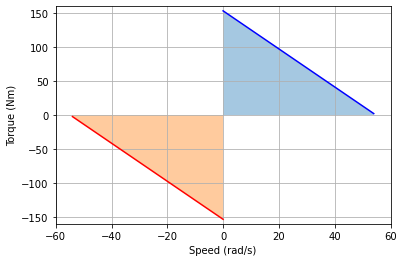

In [13]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')

In [14]:
# m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (0.0,38.0))

In [15]:
'''Constant Power - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.signs, m.sides,bounds = (0.0,38.0))
m.tau_velocity = Var(m.N, m.signs, m.sides,bounds = (0.0,46.0))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,'+ve',side]-m.tau_velocity[n,'-ve',side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power(m,n,sign,side):
    if sign == '+ve':
        return m.tau_torque[n,sign,side] <= m.tau_velocity[n,sign,side]*(-2.8) + 153.4
    else:
        return m.tau_torque[n,sign,side] >= m.tau_velocity[n,sign,side]*(-2.8) - 153.4
m.constant_power = Constraint(m.N, m.signs, m.sides,rule = def_constant_power)

In [16]:
m.Fp = Var(m.N, m.sides, bounds = (-50.0,50.0))

<a id='initial_conditions'></a>

In [17]:
''' Use this code for tests '''

# BOUND VALUES
sign_symbols = ['+','-']
boundaries = ['setub','setlb']

for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/3))
    m.q[n,'theta_body'].setlb(np.pi*(-1/3))
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    for foot in feet:
        m.GRF_y[n,foot].setlb(0.0)
        m.GRF_y[n,foot].setub(10*total_mass*m.g.value)
        
        for sgn in signs:
            m.GRF_x[n,sgn,foot].setlb(0.0)
            m.GRF_x[n,sgn,foot].setub(10*total_mass*m.g.value)  
    
        
    for index in range(len(boundaries)):
        eval('m.q[n,\'theta_UL\'].{0}(np.pi*({1}1/3))'.format(boundaries[index],sign_symbols[index]))  
        eval('m.q[n,\'theta_UR\'].{0}(np.pi*({1}1/3))'.format(boundaries[index],sign_symbols[index]))    

    
    if test == "Periodic_Walk":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test":
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        if test == "Drop_Hop_Test":
            [m.tau_torque[1,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.Fp[1,side].fix(0.0) for side in sides]
        else:
            [m.tau_torque[n,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.Fp[n,side].fix(0.0) for side in sides]
        

    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Walk":
            pass
        else:
            [m.tau_torque[1,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.Fp[1,side].fix(0.0) for side in sides]

In [18]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(1/6))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(0.5-0.1))
    m.q[1,'theta_UR'].fix(np.pi*(0.5+0.1))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(0.5-0.1))
    m.q[N,'theta_UR'].setlb(np.pi*(0.5+0.1))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(0.5-0.1))
    m.q[1,'theta_UR'].fix(np.pi*(0.5+0.1))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)
    
elif test == "Periodic_Walk":
#    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
#     for n in range(1,N+1):
#         m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
#         m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
#         m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
#         m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day
    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    
else: pass

In [19]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    # T = sum(m.h[n] for n in range(1,N+1)) # minimum time
    row = 1e4 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
        
            for side in sides:
                tau_sum += (m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])**2 
                if test == "Periodic_Walk":
                    transport_sum += ((m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
                    
    return row*pen_sum #+ transport_sum #+ tau_sum + transport_sum #+ T + tau_sum
m.Cost = Objective(rule = CostFun)

In [20]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [21]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    11345
Number of nonzeros in inequality constraint Jacobian.:     1686
Number of nonzeros in Lagrangian Hessian.............:     5139

Total number of variables............................:     2840
                     variables with only lower bounds:      900
                variables with lower and upper bounds:     1092
                     variables with only upp

  77  1.7663516e-01 9.43e-03 4.10e+00  -5.7 2.67e-02  -1.8 3.37e-02 1.68e-02h  1
  78  1.7638929e-01 9.37e-03 4.07e+00  -5.7 1.29e-01  -1.4 3.44e-03 5.99e-03f  1
  79  1.7649561e-01 8.79e-03 5.91e+00  -5.7 6.67e-03   0.8 1.61e-01 6.26e-02f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.7728075e-01 1.06e-06 8.76e-01  -5.7 6.27e-03   2.1 1.00e+00 1.00e+00h  1
  81  1.7648842e-01 1.43e-08 1.99e-03  -5.7 4.31e-05   1.7 1.00e+00 1.00e+00h  1
  82  1.7621342e-01 9.80e-09 1.44e-03  -5.7 9.27e-05   1.2 1.00e+00 1.00e+00h  1
  83  1.7613544e-01 9.80e-09 6.29e-04  -5.7 1.18e-04   0.7 1.00e+00 1.00e+00h  1
  84  1.7612853e-01 9.80e-09 1.46e-04  -5.7 8.17e-05   0.2 1.00e+00 1.00e+00h  1
  85  1.7612854e-01 9.80e-09 3.05e-05  -5.7 4.45e-05  -0.2 1.00e+00 1.00e+00h  1
  86  1.7613046e-01 9.79e-09 1.56e-05  -5.7 8.12e-05  -0.7 1.00e+00 1.00e+00h  1
  87  3.8270861e-03 9.95e-09 5.52e+01  -7.0 2.33e-04  -1.2 1.00e+00 8.35e-01f  1
  88 -2.9840600e-02 9.99e-09

 173 -3.5297688e-02 2.14e-03 1.17e-01  -7.0 1.41e-01  -4.3 1.00e+00 1.00e+00h  1
 174 -3.5332993e-02 1.42e-05 7.41e-02  -7.0 3.25e-02  -4.8 1.00e+00 1.00e+00h  1
 175 -3.5365747e-02 2.46e-05 1.42e+00  -7.0 9.04e-02  -5.3 9.75e-01 1.00e+00h  1
 176 -3.5385521e-02 3.60e-06 2.89e-01  -7.0 2.55e-02  -4.8 1.00e+00 1.00e+00h  1
 177 -3.5427022e-02 1.10e-05 2.36e+00  -7.0 1.33e-01  -5.3 9.75e-01 1.00e+00H  1
 178 -3.5465559e-02 7.48e-05 1.88e+01  -7.0 5.60e-01  -5.8 1.00e+00 1.00e+00H  1
 179 -3.5497165e-02 3.84e-04 9.42e+00  -7.0 4.81e-01  -6.3 8.36e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 -3.5537032e-02 8.10e-04 2.45e+01  -7.0 1.65e+00  -6.7 5.91e-01 6.22e-01h  1
 181 -3.5602760e-02 1.14e-02 1.60e+01  -7.0 9.63e-01  -7.2 1.00e+00 1.00e+00f  1
 182 -3.5696726e-02 5.08e-02 1.77e+01  -7.0 2.02e+00  -7.7 9.13e-01 1.00e+00h  1
 183 -3.5760952e-02 1.22e-01 1.06e+01  -7.0 3.25e+00  -8.2 5.56e-01 7.03e-01h  1
 184 -3.5774219e-02 3.22e-02

In [22]:
print(results.solver.termination_condition) # check if optimal

optimal


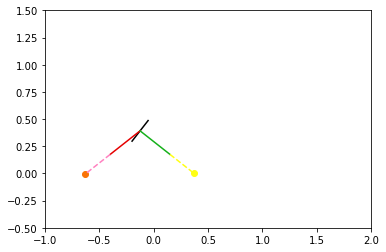

In [23]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value - m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[4]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[-10,-10]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [24]:
print(results.solver.termination_condition) # check if optimal

optimal


In [25]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

102

In [31]:
vel = 0.0

for n in range(1,N+1):
    #print(m.ddq[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
#     print(m.dq[n,'x_body'].value)
#     vel = vel + m.dq[n,'x_body'].value
    
vel/TT

0.6391223503128473
0.6239967140801437
0.6128202281263171
0.6044155484523497
0.5978399879437718
0.5923184378565981
0.587280426574268
0.582340312443494
0.5772537943460861
0.5718778365317355
0.5661387952577799
0.5600078453702034
0.5534827656752279
0.5465752757621989
0.539302927350581
0.5316844191830531
0.5237372635110824
0.51547692184564
0.5069167550524227
0.4980683409428737
0.488941878537129
0.47954651832728257
0.4698905365750711
0.4599813165098405
0.44982511862402674
0.4394266240788219
0.428788226598131
0.41790903530424367
0.40678353943603174
0.39539988174236035
0.3837376974772309
0.3717655085720727
0.35943772666579715
0.3466914213693151
0.3334431510104409
0.31958631391026787
0.304989608155624
0.2894971876628652
0.27293081725200424
0.25509356853776305
0.23577321173925572
0.21474150647072027
0.1917435857535837
0.16647064534296516
0.13851080246755215
0.10728060630467777
0.07196477806944865
0.031564917260403814
0.02367016023437902
-4.998263395768222e-09


0.0

In [27]:
tau_sum_value = 0.0
pen_sum_value = 0.0
transport_sum_value = 0.0

for n in range(1,N+1):

        for side in sides:
            tau_sum_value += (m.tau_torque[n,'+ve',side].value-m.tau_torque[n,'-ve',side].value)**2 
            transport_sum_value += ((m.tau_torque[n,'+ve',side].value-m.tau_torque[n,'-ve',side].value)**2)/(x_final)

        for gc in ground_constraints:
            for foot in feet:
                pen_sum_value += m.ground_penalty[n,gc,foot].value 
                
print(pen_sum_value*(10**4))
print(transport_sum_value)

-0.03603770957955617
1888.382675773381


In [28]:
dd_ullA_plot = []
dd_yb_plot = []
GRF_Y_plot = []
left_knee = []
right_knee = []
left_torque = []

for n in N_time:
    for leg in legs:
        GRF_Y_plot.append(m.GRF_y[n,'A'].value)
        dd_ullA_plot.append(m.ddq[n,'theta_urlA'].value)
        dd_yb_plot.append(m.ddq[n,'y_body'].value)
        left_knee.append(2*np.pi - m.q[n,'theta_lll'+leg].value)
        left_torque.append(m.tau_torque[n,'+ve','left','A'].value-m.tau_torque[n,'-ve','left','A'].value)
    
# plt.plot(N_time[2:],dd_ullA_plot[2:])
plt.plot(N_time[:],GRF_Y_plot[:])
# plt.figure()
# plt.plot(N_time,right_tau)

NameError: name 'legs' is not defined

In [ ]:
print(results.solver.termination_condition) # check if optimal

### <a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>